In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
import pandas as pd

In [3]:
info = load_diabetes()
X = pd.DataFrame(info["data"],
                           columns=info["feature_names"])
Y = pd.Series(info["target"])
X_columns = X.columns
# X.to_csv("features_data.csv")
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


### Make data more dirty

In [4]:
import numpy as np
import random
np.random.seed(40)

random_col = np.random.choice(X_columns, size=7, replace=False)

for col in random_col:
    list_of_random_row = []
    random_indices = random.randint(5, 25)

    for i in range(0 , random_indices):

        random_row = random.randint(0, len(X)-1)

        if random_row not in list_of_random_row:
            type_of_dirty = ["missing", "outlier", "unnormal-data"]
            type = random.choice(type_of_dirty)

            if(type == "missing"):
                X.loc[random_row, col] = np.nan
            
            if(type == "outlier"):
                max_col = X[col].max()
                min_col = X[col].min()
                X.loc[random_row, col] = (max_col + (max_col-min_col) * 2)
            
            if(type == "unnormal-data"):
                unnoraml_data = [12321, -1000]
                X.loc[random_row, col] = random.choice(unnoraml_data)
            
            list_of_random_row.append(random_row)

### Cleaning and Preprocessing on Data

In [5]:
X_train, X_test, Y_train, Y_Test = train_test_split(X, Y, random_state=42,
                                                    shuffle=True, test_size=0.2)

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>, <Axes: >, <Axes: >]], dtype=object)

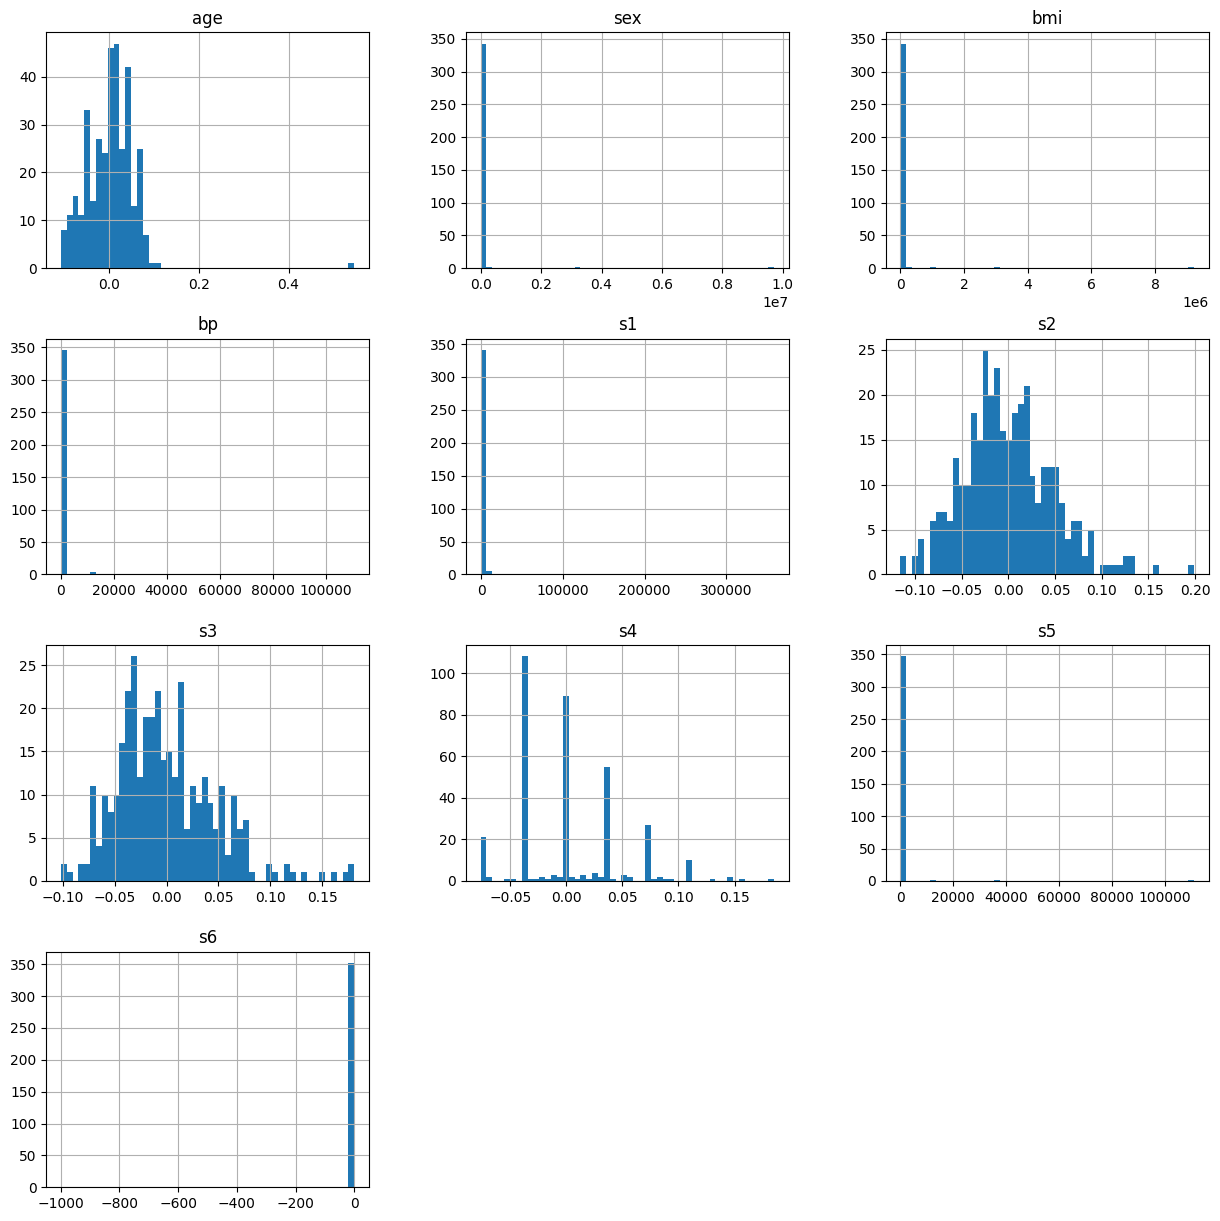

In [6]:
X_train.hist(bins=50, figsize=(15, 15))

In [7]:
from sklearn.pipeline import Pipeline

def wensorize(X:pd.DataFrame, columns:list):
    X = X.copy()
    
    for col in columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3- Q1
        
        outliers_over_limitation = X[col] > Q3 + 1.5 * IQR
        outliers_under_limitation = X[col] < Q1 - 1.5 * IQR
        X.loc[outliers_over_limitation, col] = Q3 + 1.5 * IQR
        X.loc[outliers_under_limitation, col] = Q1 - 1.5 * IQR
    
    return X

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin


class Winsorizer(BaseEstimator, TransformerMixin):

    def __init__(self, columns, lower=1.5, upper=1.5):
        self.columns = columns
        self.upper = upper
        self.lower = lower
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
    
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3- Q1
        
            outliers_over_limitation = X[col] > Q3 + self.upper * IQR
            outliers_under_limitation = X[col] < Q1 - self.lower * IQR
            X.loc[outliers_over_limitation, col] = Q3 + self.upper * IQR
            X.loc[outliers_under_limitation, col] = Q1 - self.lower * IQR
        
        return X

In [9]:
import seaborn as sns

<Axes: xlabel='age', ylabel='bmi'>

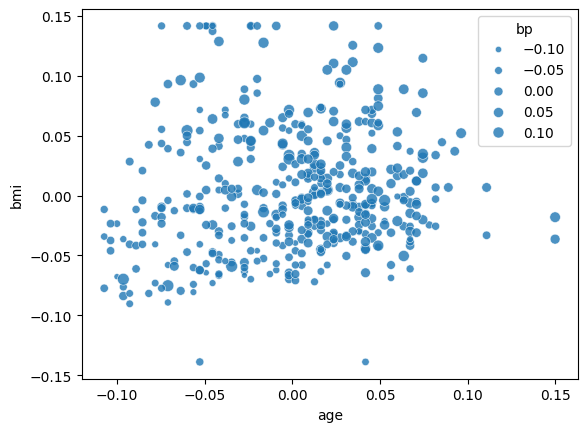

In [10]:
X_copied = X.copy()
win1 = Winsorizer(X_copied.columns)
X_copied = win1.transform(X_copied)

sns.scatterplot(X_copied, x="age", y="bmi", alpha=0.8, size="bp")

In [11]:
X_train["ratio_s1"] = X_train["s1"] / X_train["bmi"]
X_test["ratio_s1"] = X_test["s1"] / X_test["bmi"]

X_train["ratio_age/s5"] = X_train["age"] / X_train["s5"]
X_test["ratio_age/s5"] = X_test["age"] / X_test["s5"]

corr_with_taget = X_train.corrwith(pd.Series(Y_train))
corr_with_taget

age             0.123632
sex             0.008505
bmi            -0.038256
bp             -0.074900
s1             -0.024056
s2              0.154922
s3             -0.384000
s4              0.425094
s5              0.011332
s6              0.069917
ratio_s1        0.017365
ratio_age/s5    0.009453
dtype: float64

In [12]:
winsorizer = Winsorizer(X_train.columns, lower=2.5, upper=1.5)

pipeline = Pipeline([
    ("winsorize", winsorizer),
    ("imputer", SimpleImputer(strategy="median")),
    ("power-transformer", PowerTransformer()),
    ("standard-scaling", StandardScaler())
])

In [13]:
a = X_train.copy()
X_train_after_processing = pd.DataFrame(pipeline.fit_transform(a),
                                        columns=X_train.columns)

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>,
        <Axes: title={'center': 'ratio_s1'}>,
        <Axes: title={'center': 'ratio_age/s5'}>]], dtype=object)

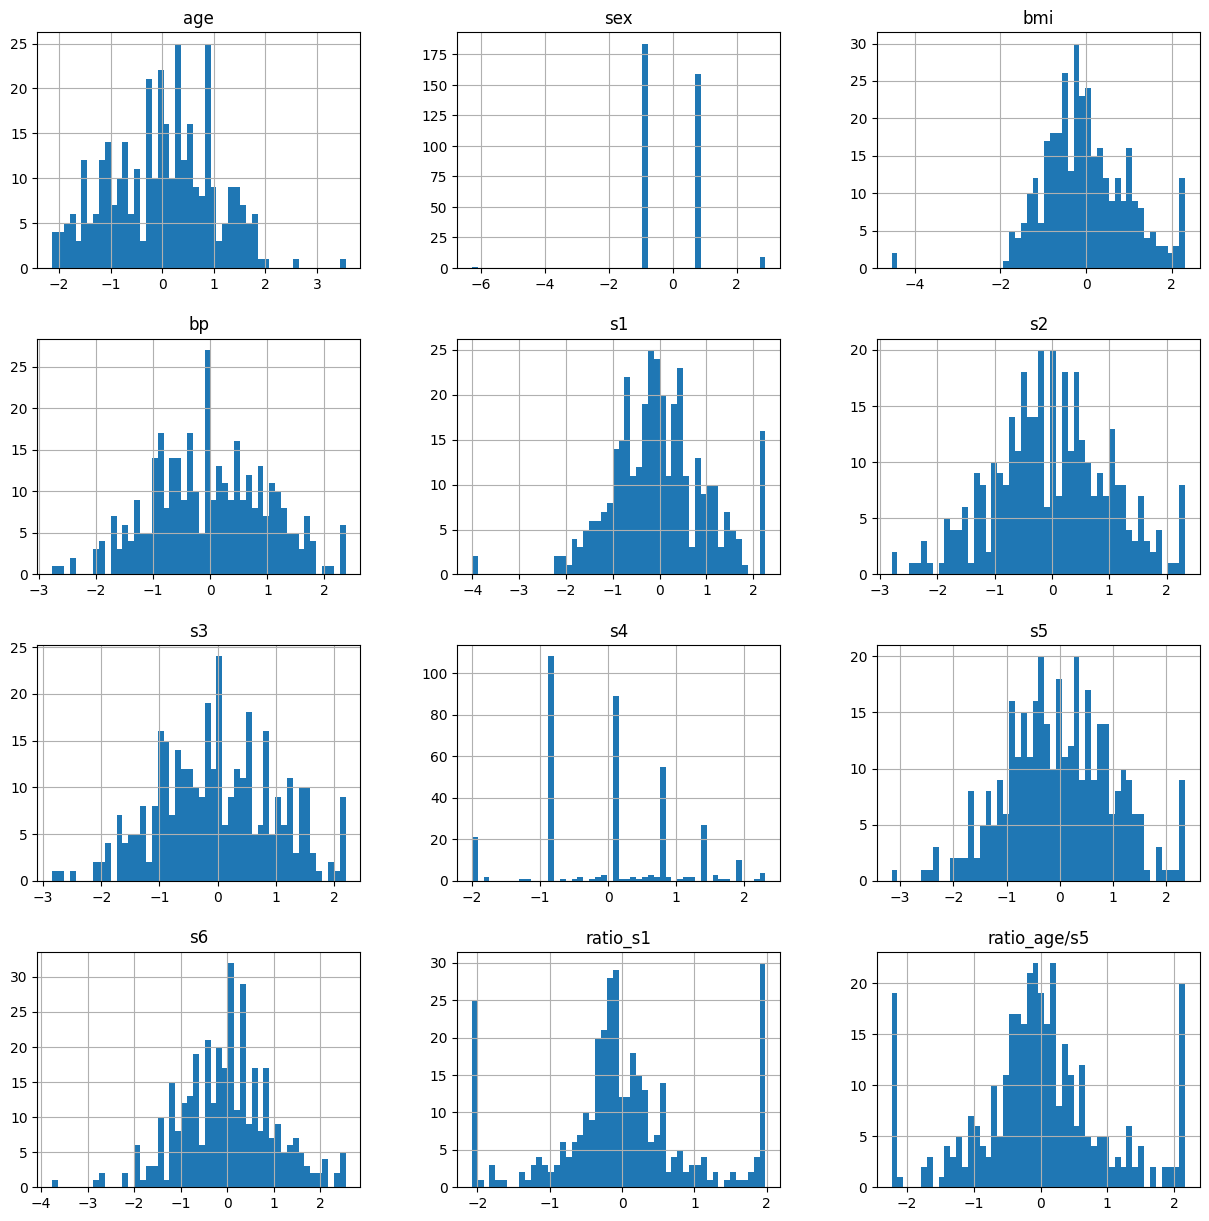

In [14]:
X_train_after_processing.hist(bins=50, figsize=(15, 15))

### Chose the best model with hyperparameters

#### Tree Base Models

##### Decision Tree

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
X_columns = X_train.columns
decision_tree_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", DecisionTreeRegressor())
])

In [17]:
from sklearn.model_selection import cross_val_score
mean_error_score = -1 * cross_val_score(decision_tree_pipeline, X_train, Y_train,
                                        scoring="neg_mean_absolute_error",
                                        cv=5)
pd.Series(mean_error_score).describe()

count     5.000000
mean     66.057666
std       6.590492
min      57.742857
25%      61.985915
50%      65.728571
75%      70.535211
max      74.295775
dtype: float64

In [18]:
pd.Series(Y_train).describe()

count    353.000000
mean     153.736544
std       78.061902
min       25.000000
25%       86.000000
50%      142.000000
75%      214.000000
max      346.000000
dtype: float64

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error

decision_tree_pipeline.fit(X_train, Y_train)
Y_pred_train = decision_tree_pipeline.predict(X_train)

r2_score(Y_train, Y_pred_train)

1.0

In [20]:
cross_r2_score = cross_val_score(decision_tree_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=5)
pd.Series(cross_r2_score).describe()

count    5.000000
mean    -0.127002
std      0.271308
min     -0.410640
25%     -0.401300
50%     -0.060394
75%      0.036190
max      0.201134
dtype: float64

In [21]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [22]:
dt_dist = {
    "model__max_depth": [None] + list(range(3, 10)),
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5 ,10],
    "model__max_features": [None, "sqrt", "log2", 0.3, 0.5, 0.7],
    "model__ccp_alpha": np.linspace(0.0, 0.01, 50)
}

rsCV = RandomizedSearchCV(decision_tree_pipeline,
                         param_distributions= dt_dist,
                         n_iter=500,
                         scoring="r2",
                         cv=5,
                         n_jobs=-1, random_state=42)
# rsCV.fit(X_train, Y_train)
# rsCV.best_params_    >>>>>>>>>>>
{'model__min_samples_split': 10,
 'model__min_samples_leaf': 2,
 'model__max_features': 'log2',
 'model__max_depth': 3,
 'model__ccp_alpha': np.float64(0.00836734693877551)}

{'model__min_samples_split': 10,
 'model__min_samples_leaf': 2,
 'model__max_features': 'log2',
 'model__max_depth': 3,
 'model__ccp_alpha': np.float64(0.00836734693877551)}

In [23]:
decision_tree_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", DecisionTreeRegressor(min_samples_split=5,
                                    min_samples_leaf=5,
                                    max_features=0.7,
                                    max_depth=3,
                                    ccp_alpha=0.01
                                    ))
])
decision_tree_pipeline.fit(X_train, Y_train)

cross_r2_score = cross_val_score(decision_tree_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=5)
pd.Series(cross_r2_score).describe()

count    5.000000
mean     0.290805
std      0.169749
min      0.112306
25%      0.117314
50%      0.338322
75%      0.394631
max      0.491454
dtype: float64

In [24]:
r2_score(Y_Test, decision_tree_pipeline.predict(X_test))

0.4269955189705388

##### Random Forest

In [25]:
random_forest_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", RandomForestRegressor())
])
random_forest_pipeline.fit(X_train, Y_train)

cross_r2_score = cross_val_score(random_forest_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=5)
pd.Series(cross_r2_score).describe()

count    5.000000
mean     0.372036
std      0.155707
min      0.171625
25%      0.250631
50%      0.415546
75%      0.484214
max      0.538164
dtype: float64

In [26]:
rf_dist = {
    "model__n_estimators": np.arange(200, 1200, 50),
    "model__max_depth": [None] + list(range(3, 20)),
    "model__min_samples_split": np.arange(2, 40),
    "model__min_samples_leaf": np.arange(1, 30),
    "model__max_features": ["sqrt", "log2", None, 0.3, 0.5, 0.7],
    "model__bootstrap": [True, False],
    "model__ccp_alpha": np.linspace(0.0, 0.05, 50),
    "preprocessing__winsorize__upper": np.linspace(0.5, 3, 6),
    "preprocessing__winsorize__lower": np.linspace(0.5, 3, 6)
}

rsCV = RandomizedSearchCV(random_forest_pipeline, 
                          param_distributions=rf_dist,
                          scoring="r2",
                          n_iter=150, cv=5,
                          random_state=42)
# rsCV.fit(X_train, Y_train)
# rsCV.best_params_     >>>>>
{'model__n_estimators': np.int64(750),
 'model__min_samples_split': np.int64(12),
 'model__min_samples_leaf': np.int64(8),
 'model__max_features': 0.5,
 'model__max_depth': 19,
 'model__ccp_alpha': np.float64(0.03571428571428572),
 'model__bootstrap': True,
 'preprocessing__winsorize__lower': np.float64(2.5),
 'preprocessing__winsorize__upper': np.float64(1.5)}

{'model__n_estimators': np.int64(750),
 'model__min_samples_split': np.int64(12),
 'model__min_samples_leaf': np.int64(8),
 'model__max_features': 0.5,
 'model__max_depth': 19,
 'model__ccp_alpha': np.float64(0.03571428571428572),
 'model__bootstrap': True,
 'preprocessing__winsorize__lower': np.float64(2.5),
 'preprocessing__winsorize__upper': np.float64(1.5)}

In [47]:
random_forest_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", RandomForestRegressor(n_estimators=750,
                                    min_samples_split=12,
                                    min_samples_leaf=8,
                                    max_features=0.5,
                                    max_depth=19,
                                    ccp_alpha=0.03571428571428572,
                                    bootstrap=True))
])
random_forest_pipeline.fit(X_train, Y_train)
cross_r2_score = cross_val_score(random_forest_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=5)
pd.Series(cross_r2_score).describe()

count    5.000000
mean     0.398710
std      0.130352
min      0.254463
25%      0.275615
50%      0.422441
75%      0.490758
max      0.550271
dtype: float64

In [28]:
r2_score(Y_train, random_forest_pipeline.predict(X_train))

0.656648264831572

In [29]:
mean_absolute_error(Y_train, random_forest_pipeline.predict(X_train))

37.70598381965423

In [30]:
r2_score(Y_Test, random_forest_pipeline.predict(X_test))

0.49616651488223595

In [31]:
mean_absolute_error(Y_Test, random_forest_pipeline.predict(X_test))

42.29187095878843

#### Linear Model

##### Ridge

In [32]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

linear_ridge_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", Ridge())
])
linear_ridge_pipeline.fit(X_train, Y_train)
cross_r2_score = cross_val_score(linear_ridge_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=10)
pd.Series(cross_r2_score).describe()

count    10.000000
mean      0.313468
std       0.262936
min      -0.188521
25%       0.234247
50%       0.373642
75%       0.493073
max       0.675434
dtype: float64

In [33]:
r2_score(Y_Test, linear_ridge_pipeline.predict(X_test))

0.46592447679948257

In [34]:
params = {"model__alpha": np.logspace(-3, 3, 100), 
          "model__fit_intercept": [False, True]}

rsCV = RandomizedSearchCV(linear_ridge_pipeline,
                          param_distributions= params,
                          n_iter=150,
                          cv=5,
                          scoring="r2",
                          random_state=42)
# rsCV.fit(X_train, Y_train)
# rsCV.best_params_     >>>>>>
{'model__fit_intercept': True, 'model__alpha': np.float64(40.37017258596558)}

{'model__fit_intercept': True, 'model__alpha': np.float64(40.37017258596558)}

In [35]:
linear_ridge_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", Ridge(fit_intercept=True,
                    alpha=46.41588833612782))
])
linear_ridge_pipeline.fit(X_train, Y_train)
cross_r2_score = cross_val_score(linear_ridge_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=10)
pd.Series(cross_r2_score).describe()

count    10.000000
mean      0.335376
std       0.250598
min      -0.142354
25%       0.287296
50%       0.376062
75%       0.500682
max       0.671349
dtype: float64

In [36]:
r2_score(Y_Test, linear_ridge_pipeline.predict(X_test))

0.46584410116805963

##### Lasso

In [37]:
linear_lasso_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", Lasso())
])
linear_lasso_pipeline.fit(X_train, Y_train)
cross_r2_score = cross_val_score(linear_lasso_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=10)
pd.Series(cross_r2_score).describe()

count    10.000000
mean      0.329332
std       0.257648
min      -0.159206
25%       0.280008
50%       0.363578
75%       0.504520
max       0.680051
dtype: float64

In [38]:
params = {"model__alpha": np.logspace(-3, 3, 100), 
          "model__fit_intercept": [False, True]}

rsCV = RandomizedSearchCV(linear_lasso_pipeline,
                          param_distributions= params,
                          n_iter=150,
                          cv=5,
                          scoring="r2",
                          random_state=42)
# rsCV.fit(X_train, Y_train)
# rsCV.best_params_   >>>>>>

{'model__fit_intercept': True, 'model__alpha': np.float64(2.848035868435802)}

{'model__fit_intercept': True, 'model__alpha': np.float64(2.848035868435802)}

In [39]:
linear_lasso_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", Lasso(fit_intercept=True,
                    alpha=2.848035868435802))
])
linear_lasso_pipeline.fit(X_train, Y_train)
cross_r2_score = cross_val_score(linear_lasso_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=10)
pd.Series(cross_r2_score).describe()

count    10.000000
mean      0.344167
std       0.248306
min      -0.124148
25%       0.299118
50%       0.396287
75%       0.507971
max       0.677808
dtype: float64

In [40]:
r2_score(Y_Test, linear_lasso_pipeline.predict(X_test))

0.4786091876597425

##### Elastic Net

In [41]:
linear_ElasticNet_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", ElasticNet(max_iter=5000))
])

param_dist = {
    "model__alpha": np.logspace(-3, 2, 50),
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

rsCV = RandomizedSearchCV(
    linear_ElasticNet_pipeline,
    param_distributions=param_dist,
    n_iter=150,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)
# rsCV.fit(X_train, Y_train)
# rsCV.best_params_     >>>>>>
{'model__l1_ratio': 1.0, 'model__alpha': np.float64(2.329951810515372)}

{'model__l1_ratio': 1.0, 'model__alpha': np.float64(2.329951810515372)}

In [42]:
linear_ElasticNet_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("model", ElasticNet(max_iter=5000,
                         l1_ratio=1.0,
                         alpha=2.329951810515372))
])
linear_ElasticNet_pipeline.fit(X_train, Y_train)

cross_r2_score = cross_val_score(linear_ElasticNet_pipeline,
                                        X_train, Y_train,
                                        scoring="r2",
                                        cv=10)
pd.Series(cross_r2_score).describe()

count    10.000000
mean      0.340446
std       0.250876
min      -0.132900
25%       0.294246
50%       0.397228
75%       0.503388
max       0.679550
dtype: float64

In [43]:
r2_score(Y_Test, linear_ElasticNet_pipeline.predict(X_test))

0.4798245575396155

#### Chose and save the best model

The best model after testing hyperparameter and showing r2_score and cross_val_predictaion on train and test is random foreset pipeline

In [44]:
import joblib
joblib.dump(random_forest_pipeline, "diabetes_model.pkl")

['diabetes_model.pkl']

### Visiulazation

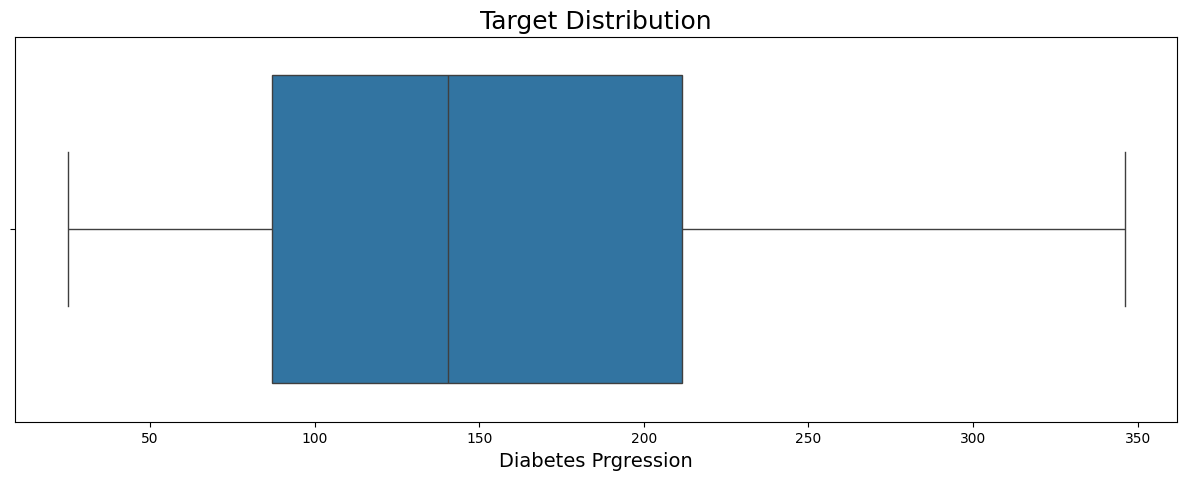

In [63]:
plt.figure(figsize=(15, 5))

sns.boxplot(x=Y)
plt.title("Target Distribution", fontsize=18)
plt.xlabel("Diabetes Prgression", fontsize=14)
plt.savefig("../results/figure/target_boxplot.png")

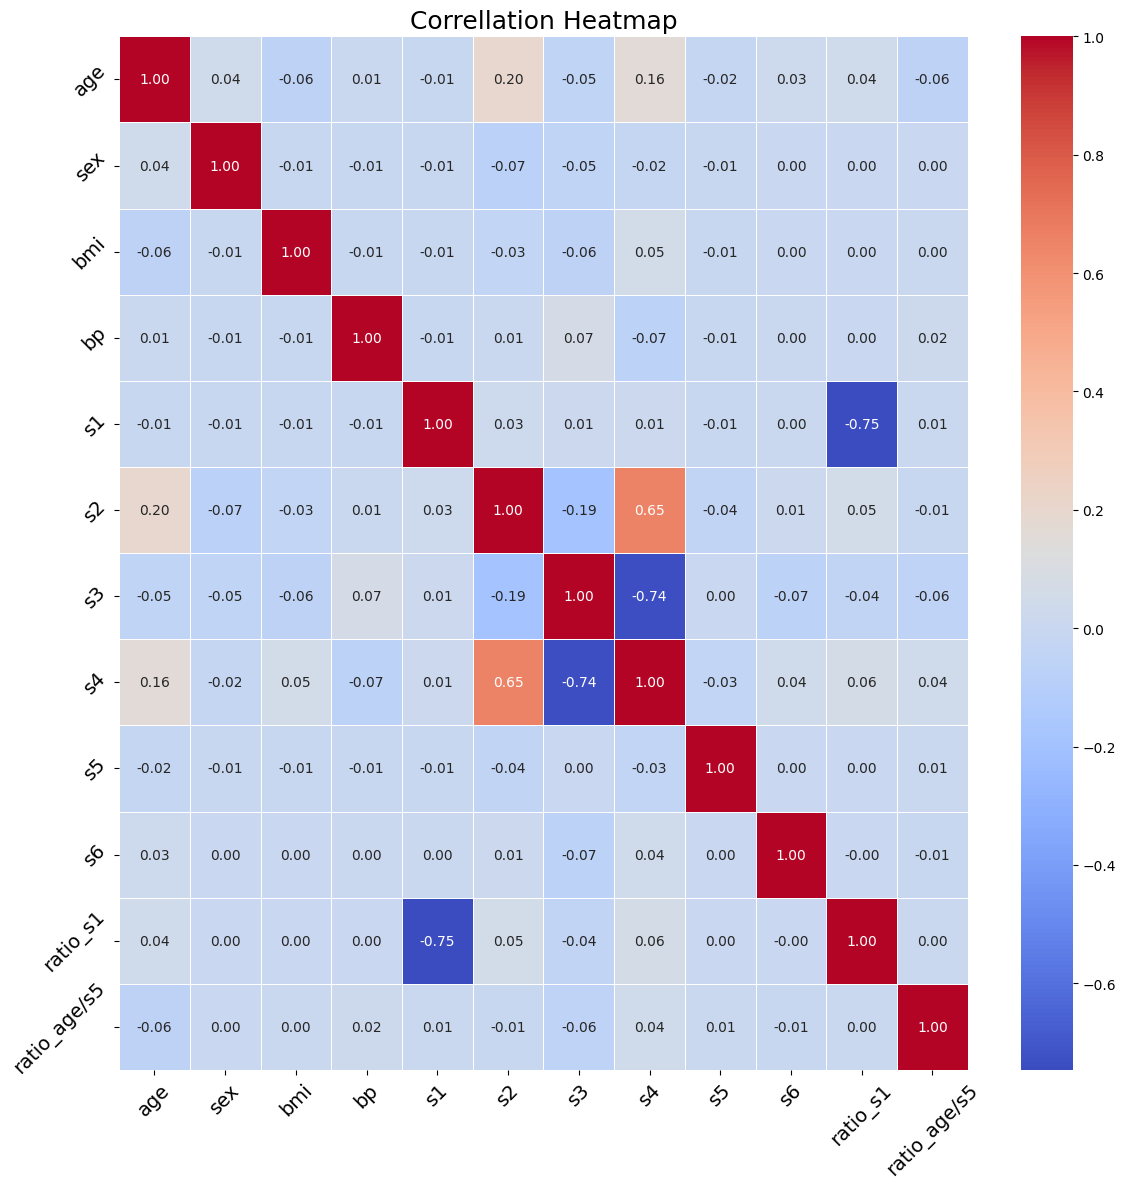

In [68]:
import matplotlib.pyplot as plt
corr = X_train.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, cmap="coolwarm")

plt.title("Correllation Heatmap", fontsize=18)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=45)

plt.tight_layout()
plt.savefig("../results/figure/features_correlation_heatmap.png", dpi=300)

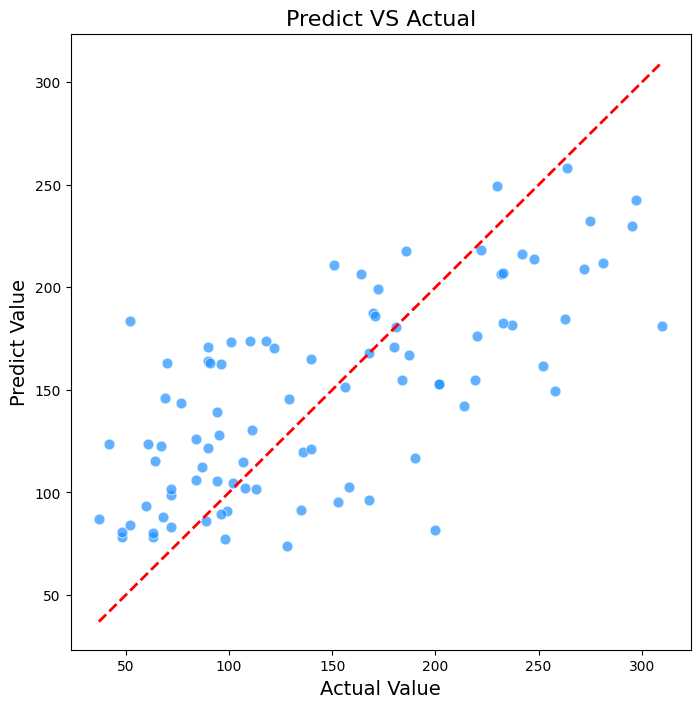

In [80]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=Y_Test,
                 y=random_forest_pipeline.predict(X_test),
                 alpha=0.7, s=60, color="dodgerblue")

plt.plot([Y_Test.min(), Y_Test.max()],
         [Y_Test.min(), Y_Test.max()],
         color='red', lw=2, linestyle='--')
plt.xlabel("Actual Value", fontsize=14)
plt.ylabel("Predict Value", fontsize=14)
plt.title("Predict VS Actual", fontsize=16)

plt.savefig("../results/figure/pred_vs_actual.png")